---
title: "With "
author: "Sarem"
date: "2024-01-18"
categories: [Decision Trees, Gradient Boosting]
format:
  html:
    toc: true
    toc-location: left
    toc-depth: 2
    toc-title: Contents
description-meta: "How PyTorch can make your Gradient Boosting models more flexible"
---

## Introduction

[Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting) is a powerful machine learning technique that can be used for both regression and classification problems. Its fundamental idea is to combine weak, almost trivial base model into a single strong ensemble. A fairly unique feature of Gradient Boosting is the loss minimization by calculating derivatives with respect to the model output, rather than model parameters. 

This allows for the distinct capability to use non-differentiable models as a base learner, typically decision trees. In fact, there is probably not a single popular Gradient Boosting library that does not rely on trees. This allows Boosting models to handle complex, non-smooth data generating processes fairly well. As a result, popular implementations like [XGBoost](https://xgboost.readthedocs.io/en/latest/) and [LightGBM](https://lightgbm.readthedocs.io/en/latest/) regularly dominate Kaggle competitions and the like.

PyTorch on the other hand is rather well known for programming Deep Learning type models. Thus, the idea to use PyTorch for Gradient Boosting might seem a bit odd at first. However, its capabilities are not limited to just Neural Networks but it is actually a much richer framework for anything [AutoDiff](https://en.wikipedia.org/wiki/Automatic_differentiation). Whatever function we can express in its domain language, PyTorch will find the corresponding derivatives.

Hence, it should be interesting to let PyTorch find the deriviatives for increasingly complex loss functions. Then, we can apply the standard Gradinent Boosting algorithm to fit simple Decision Trees to those derivatives. This way, we can hopefully create models that are more flexible than standard Gradient Boosting implementations, but still as powerful.

## A quick recap on Gradient Boosting

As already mentioned, in Gradient Boosting we are interested in the derivatives of the loss function with respect to the model output:

$$\frac{\partial L(\hat{F}(x),y)}{\partial \hat{F}(x)}$$

Notice that, here, we don't use the chain rule to extend the above to the model parameters. Rather, we stick to the above and perform gradient descent in, roughly speaking, function space. At each gradient descent step, we fit our base learner to the negative gradients with respect to the previous round's model output:

$$\hat{f}_{m+1} = \underset{<parameter>}{\text{argmin}}\frac{1}{N}\sum_{i=1}^N
\left(\frac{\partial L(\hat{F}_{m-1}(x_i),y_i)}{\partial \hat{F}_{m-1}(x_i)}- f(x_i)\right)^2$$

Here, $\hat{F}_{m-1}$ is the ensemble of the first $m-1$ base learners, denoted as $\hat{f}_j$. Notice also that the [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) criterion is not necessarily the only one possible. For simplicity, we will stick to it in this post, though. 


### Word of caution

As an important side-note, consider the following: If we use the squared loss, i.e.

$$L(\hat{F}(x),y) = 0.5\left(y-\hat{F}(x)\right)^2,$$

the derivative with respect to the model output is simply the residual:

$$\frac{\partial L(\hat{F}(x),y)}{\partial \hat{f}(x)} = y-\hat{F}(x)$$

If you first learn about Gradient Boosting in the context of regression, you might now be tempted to think that your base learner should always estimate the residual. Given the above, however, this is obviously not the case. 

### Updating the ensemble

Next, we want to update our ensemble by adding the new base learner. As already mentioned, we do this by performing what looks like a gradient descent step in function space:

$$\hat{F}_m(x) = \hat{F}_{m-1}(x) - \gamma \hat{f}_m(x)$$

Here, $\gamma$ is the learning rate. In practice, we usually use a small value like 0.01 or 0.001.

### Initializing the ensemble

The final question that remains is how to initialize the ensemble. Since our goal is to minimize the loss function, we should use a model that acts accordingly. This initial model is typically just a constant value, set as the minimum of the loss function for all training inputs:

$$\hat{f}_0(x) = \argmin_{c} \frac{1}{N}\sum_{i=1}^N L(c,y_i)$$

For the MSE loss, [this is simply the mean of the target values](https://math.stackexchange.com/questions/2554243/understanding-the-mean-minimizes-the-mean-squared-error). Keep in mind, again, that this is usually not the case for other loss functions. 

Also, you will notice that in the below examples, I won't always use the loss minimizing constant(s) to start the algorithm. While this might yield slightly worse results, it leads to less verbose code. If you want to replicate the results, you might therefore want to use the acatual loss minimizing constant(s).

### The algorithm in summary

To summarize, the algorithm for Gradient Boosting is as follows:

1. Initialize the ensemble with a constant value
2. For each round $m$:
    1. Calculate the negative gradients with respect to the previous round's model output
    2. Fit a base learner to the negative gradients
    3. Update the ensemble by performing a gradient descent step in function space


## Gradient Boosting for conditional probability distributions

If you come from a Statistics background, you might be saddened by the lack of libraries for probabilistic Gradient Boosting. Despite the countless probability distributions that could well suit your data, you are usually limited to Bernoulli/Multinomial distributions via cross-entropy losses.

Thus, without further ado, let's see how PyTorch can solve this problem for us. While we will implement the algorithm for a Gaussian distribution, it should be fairly easy to extend it to other distributions. The most characteristic feature here is that we need a Boosting model for each of the distribution's parameters. In the Gaussian case, this means two models for the mean and standard deviation, respectively. Let us exemplify this by writing our full model as a stacked vector of two models:

$$F(x)=\begin{bmatrix}F^{(1)}(x) \\ F^{(2)}(x)\end{bmatrix}$$

In addition, we also need to ensure that the parameters are valid, i.e. positive for the standard deviation. Thus, we also have to map the output of the corresponding Gradient Boosting model to the positive, non-zero reals. This can be done, for example, via the $\exp$-function. 

For a single input $x$, the full probabilistic description is now the following:

$$p(y|x)=\mathcal{N}(y|F^{(1)}(x), \exp{(F^{(2)}(x))})$$

As usual for probabilistic models, we will use the [negative log-likelihood](https://en.wikipedia.org/wiki/Likelihood_function#Log-likelihood) as our loss function:

$$L(F(x),y)=-\log p(y|x) = - \log\mathcal{N}(y|F^{(1)}(x), \exp{(F^{(2)}(x))})$$

To initialize the model, we can use the [maximum likelihood estimates](https://www.statlect.com/fundamentals-of-statistics/normal-distribution-maximum-likelihood#:~:text=Proof-,The%20maximum%20likelihood%20estimators,-The%20maximum%20likelihood) for the mean and standard deviation:

$$\hat{F}^{(1)}_0(x) = \frac{1}{N}\sum_{i=1}^N y_i$$

and

$$\hat{F}^{(2)}_0(x) = \sqrt{\frac{1}{N}\sum_{i=1}^N (y_i-\hat{F}^{(1)}(x))^2}.$$

Finally, we calculate the logarithm of $\hat{F}^{(2)}_0(x)$ to account for the exponentiation in the loss function. Keep in mind that the latter is not necessarily the optimtal initialization. However, it is a good starting point for our experiments.

We can now code our model as follows:



In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

import torch
from torch.distributions.normal import Normal
from torch.autograd import Variable

from typing import List, Optional

class GaussianGradientBoosting:

    def __init__(self,
                 learning_rate: float = 0.025,
                 max_depth: int = 1,
                 n_estimators: int =100):

        self.learning_rate: float = learning_rate
        self.max_depth: int = max_depth
        self.n_estimators: int = n_estimators

        self.init_mu: Optional[float] = None
        self.mu_trees: List[DecisionTreeRegressor] = []
        
        self.init_sigma: Optional[float] = None
        self.sigma_trees: List[DecisionTreeRegressor] = []
        
        self.is_trained: bool = False

    def predict(self, X: np.array) -> np.array:
        assert self.is_trained

        mus = self._predict_mus(X).reshape(-1,1)
        log_sigmas = np.exp(self._predict_log_sigmas(X).reshape(-1,1))

        return np.concatenate([mus, log_sigmas], 1) 

    def _predict_raw(self, X: np.array) -> np.array:
        assert self.is_trained

        mus = self._predict_mus(X).reshape(-1,1)
        log_sigmas = self._predict_log_sigmas(X).reshape(-1,1)

        return np.concatenate([mus, log_sigmas], 1) 
    

    def fit(self, X: np.array, y: np.array) -> None:
        self._fit_initial(y)

        self.is_trained = True

        for _ in range(self.n_estimators):
            y_pred = self._predict_raw(X)

            gradients = self._get_gradients(y, y_pred)

            mu_tree = DecisionTreeRegressor(max_depth=self.max_depth)
            mu_tree.fit(X, gradients[:,0])
            self.mu_trees.append(mu_tree)

            sigma_tree = DecisionTreeRegressor(max_depth=self.max_depth)
            sigma_tree.fit(X, gradients[:,1])
            self.sigma_trees.append(sigma_tree)


    def _fit_initial(self, y: np.array) -> None:
        assert not self.is_trained
        
        self.init_mu = np.mean(y)
        self.init_sigma = np.log(np.std(y))


    def _get_gradients(self, y: np.array, y_pred: np.array) -> np.array:
        y_torch = torch.tensor(y).float()
        y_pred_torch = Variable(torch.tensor(y_pred).float(), requires_grad=True)

        normal_dist = Normal(y_pred_torch[:,0], torch.exp(y_pred_torch[:,1])).log_prob(y_torch).sum()
        normal_dist.backward()

        return y_pred_torch.grad.numpy()


    def _predict_mus(self, X: np.array) -> np.array:
        output = np.zeros(len(X))

        output += self.init_mu

        for tree in self.mu_trees:
            output += self.learning_rate * tree.predict(X)

        return output

    def _predict_log_sigmas(self, X: np.array) -> np.array:
        output = np.zeros(len(X))

        output += self.init_sigma

        for tree in self.sigma_trees:
            output += self.learning_rate * tree.predict(X)

        return output
        
        
        

Let's take look at some important code fragments. In particular, the steps in ```fit``` are interesting to us:

At first, ```self._fit_initial(y)``` initializes the model via the mean and log-standard deviation as described above. Next, we iterate over the number of rounds, as defined by the ```n_estimators``` variable. The ```_predict_raw``` method calculates the models' outputs at $m-1$, then we pass the results to 
```_get_gradients```. In the latter, we then use PyTorch to differentiate the log-likelihood loss with respect to each output. Lucky for us, PyTorch already has the required log-likelihood function available via ```log_prob```:

```python
y_torch = torch.tensor(y).float()
y_pred_torch = Variable(torch.tensor(y_pred).float(), requires_grad=True)

normal_dist = Normal(y_pred_torch[:,0], torch.exp(y_pred_torch[:,1])).log_prob(y_torch).sum()
normal_dist.backward()

return y_pred_torch.grad.numpy()
```

Notice that PyTorch requires a single scalar value as the final loss. Hence we need to sum the log-likelihoods for each input. It is easy to check that the respective derivatives are still as expected:

$$\begin{gathered}
\frac{\partial \sum_{i=1}^N L(F(x_i),y_i)}{\partial F^{(m)}(x_T)} \\
=\sum_{i=1}^N \frac{\partial L(F(x_i),y_i)}{\partial F^{(m)}(x_t)} \\
= 0 + 0 + \cdots + \frac{\partial L(F(x_t),y_t)}{\partial F^{(m)}(x_t)} + 0 + \cdots + 0
\end{gathered}
$$

where $t$ denotes the index of the input $x_t$ for which we want to calculate the derivative.

In a last step, we fit two ```sklearn.tree.DecisionTreeRegressor``` to the negative gradients. Since ```log_prob``` returns the positive (="negative negative") log-likelihood, the respective gradients will already have the correct signs. 

Now, let us test our model on a simple toy problem. We define the data generating process as follows:

$$
\begin{gathered}
p(x) = \mathcal{U}(x|-3,3) \\
p(y|x) = \mathcal{N}(y|sin(x), 0.05 + 0.1 * x^2)
\end{gathered}
$$

$x$ is uniformly distributed between -3 and 3, while $y$ is normally distributed with a mean of $sin(x)$ and a standard deviation of $0.05 + 0.1 * x^2$. This makes the data heteroscedastic, i.e. the variance depends on the input $x$. As useful model should be able to capture both the conditional mean and standard deviation.

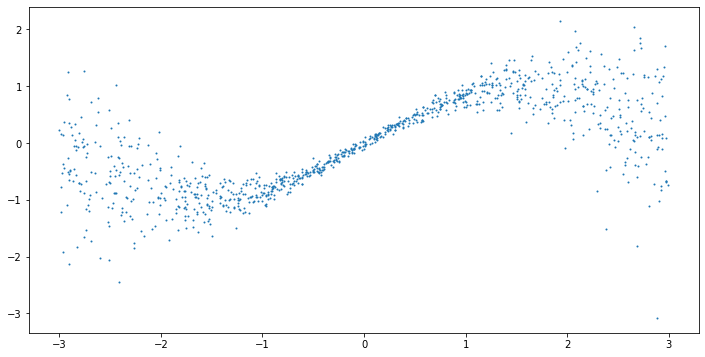

In [40]:
np.random.seed(123)

X = np.random.uniform(-3, 3, 1000).reshape(-1,1) 
y = np.sin(X).reshape(-1) + np.random.normal(0, 1, 1000) * (0.05 + 0.1 * X.reshape(-1)**2)

plt.figure(figsize=(12,6))
plt.scatter(X, y, s=1)

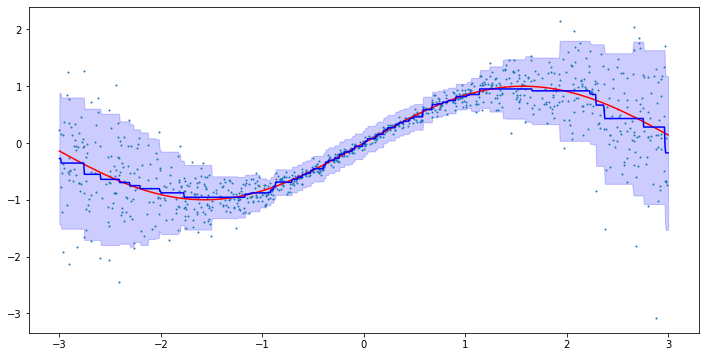

In [41]:
model = GaussianGradientBoosting(n_estimators=200)

model.fit(X, y)

line = np.linspace(-3, 3, 1000).reshape(-1,1)

predictions = model.predict(line)
mean = predictions[:,0]
std = predictions[:,1]

plt.figure(figsize=(12,6))
plt.plot(line, np.sin(line), c='r')
plt.plot(line, mean, c='b')
plt.fill_between(line.reshape(-1), mean - 2*std, mean + 2*std, color='b', alpha=0.2)
plt.scatter(X, y, s=1)


This looks pretty good! We can see that the model is able to capture both the conditional mean and standard deviation. In particular, the model is able to capture the increasing variance for larger absolute $x$. 

From here, it would be relatively easy to extend the model to other distributions. We could, for example experiment with Gamma or Log-Normal distributions to handle target values that can only be positive. More advanced models could also incorporate [censoring](https://en.wikipedia.org/wiki/Censoring_(statistics)) or [truncation](https://en.wikipedia.org/wiki/Truncated_distribution). As long as the respective log-likelihood loss is differentiable with respect to the model output, we will be able to optimize our model.

## Varying Coefficient Boosting

A fairly common problem of many sophisticated machine learning models is that they are often a black-box. While predictive power can be much better than with simpler models, it is often hard to interpret the results. Hence, a model could make biased, unfair or physically wrong predictions without us even noticing. As a result, there is a growing interest in models that are more interpretable.

One such model is [Varying Coefficient Regression](https://en.wikipedia.org/wiki/Varying-coefficient_model). Here, we assume that the coefficients of a linear regression model are not constant but rather depend on the input. In the context of Gradient Boosting, this could look as follows:

$$\hat{y} = F^{(0)}(x) + F^{(1)}(x)\cdot x^{(1)} + \cdots F^{(M)}(x)\cdot x^{(M)}$$

Here, we have $M+1$ Boosting models, one for each coefficient in a linear regression model. In a sufficiently small neighborhood around $x$, the model can then be interpreted as a linear regression model with coefficients defined by the boosting model. Once we move outside of this neighborhood, the coefficients change accordingly.

Applying the squared error criterion to our Varying Coefficient model above, we now get

$$L(F(x),y)=0.5 \left(y - \left(F^{(0)}(x) + F^{(1)}(x)\cdot x^{(1)} + \cdots F^{(M)}(x)\cdot x^{(M)}\right)\right)^2$$

Again, we can let PyTorch differentiate the above with respect to each Gradient Boosting output. To initialize the model, we could, for example, start with the (constant) OLS regression coefficient. This would be the "correct" approach, given that we typically want to start with the constant minimizer of the mean loss function over all training points. Here, however, I decided to set $F_0^{(0)}(x)=\frac{1}{N}\sum_{i=1}^N y_i$ and the remaining coefficients to zero. 

Putting all of this together, we get the following model in Python:

In [42]:
class VaryingCoefficientGradientBoosting:

    def __init__(self,
                 learning_rate: float = 0.025,
                 max_depth: int = 1,
                 n_estimators: int =100):

        self.learning_rate: float = learning_rate
        self.max_depth: int = max_depth
        self.n_estimators: int = n_estimators

        self.init_coeffs: Optional[float] = None
        self.coeff_trees: List[List[DecisionTreeRegressor]] = []
        
        self.is_trained: bool = False

    @property
    def n_coefficients(self) -> int:
        if self.is_trained:
            return self.init_coeffs.shape[1]
        else:
            return 0 

    def predict(self, X: np.array) -> np.array:
        assert self.is_trained

        X = np.concatenate([np.ones(shape = (len(X), 1)), X], 1)

        coeffs = self._predict_coeffs(X)
        predictions = np.sum(X * coeffs, 1)

        return predictions

    def _predict_raw(self, X: np.array) -> np.array:
        assert self.is_trained
        return self._predict_coeffs(X)
    

    def fit(self, X: np.array, y: np.array) -> None:
        X = np.concatenate([np.ones(shape = (len(X), 1)), X], 1)
        self._fit_initial(X, y)

        self.is_trained = True

        for _ in range(self.n_estimators):
            y_pred = self._predict_raw(X)

            gradients = self._get_gradients(X, y, y_pred)

            new_trees = []

            for c in range(self.n_coefficients):
                coeff_tree = DecisionTreeRegressor(max_depth=self.max_depth)
                coeff_tree.fit(X, gradients[:,c])

                new_trees.append(coeff_tree)

            self.coeff_trees.append(new_trees)



    def _fit_initial(self, X: np.array, y: np.array) -> None:
        assert not self.is_trained

        self.init_coeffs = np.zeros(shape = (1, X.shape[1]))
        self.init_coeffs[0,0] = np.mean(y)


    def _get_gradients(self, X: np.array, y: np.array, y_pred: np.array) -> np.array:
        X_torch = torch.tensor(X).float()
        y_torch = torch.tensor(y).float()
        y_pred_torch = Variable(torch.tensor(y_pred).float(), requires_grad=True)

        sse = -0.5 * (y_torch-(X_torch * y_pred_torch).sum(1)).pow(2.0).sum() #negative sse to get negative gradient
        sse.backward() 
        grads = y_pred_torch.grad.numpy()

        grads[grads > np.quantile(grads, 0.95)] = np.quantile(grads, 0.95)
        grads[grads < np.quantile(grads, 0.05)] = np.quantile(grads, 0.05)

        return grads


    def _predict_coeffs(self, X: np.array) -> np.array:
        output = np.zeros(shape = (len(X), self.n_coefficients))

        output += self.init_coeffs

        for tree_list in self.coeff_trees:
            for c in range(self.n_coefficients):
                output[:,c] += self.learning_rate * tree_list[c].predict(X)

        return output

This closely resembles the code for the probabilistic model from before. A key difference, however, is the following:

```python
X_torch = torch.tensor(X).float()
y_torch = torch.tensor(y).float()
y_pred_torch = Variable(torch.tensor(y_pred).float(), requires_grad=True)

mse = -0.5 * (y_torch-(X_torch * y_pred_torch).sum(1)).pow(2.0).sum()
mse.backward() 
grads = y_pred_torch.grad.numpy()

grads[grads > np.quantile(grads, 0.95)] = np.quantile(grads, 0.95)
grads[grads < np.quantile(grads, 0.05)] = np.quantile(grads, 0.05)
```

Here, we clip the gradients at the 5% and 95% quantiles. The reason for that is solely an empirical one. Keeping the raw gradients led to some fairly unstable results, i.e. the model loss would usually diverge to infinity. It might be interesting to see the theoretical reason for this, but for now, we will stick with the application side.

Notice also that we introduce the intercept term by prepending a column of ones to the input matrix:

```python
def fit(self, X: np.array, y: np.array) -> None:
    X = np.concatenate([np.ones(shape = (len(X), 1)), X], 1)
    ...
```

```python
def predict(self, X: np.array) -> np.array:
    assert self.is_trained

    X = np.concatenate([np.ones(shape = (len(X), 1)), X], 1)
    ...
```
This allows us to treat the respective intercept Boosting model like the other ones. Subsequently, some calculations become a bit simpler. 

Now, let us test the model on a simple toy problem. We define the data generating process as before, but keep the variance constant:

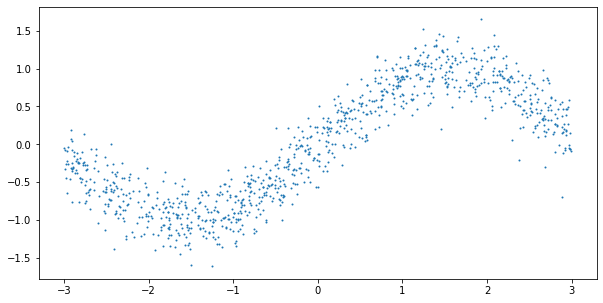

In [62]:
np.random.seed(123)

X = np.random.uniform(-3, 3, 1000).reshape(-1,1) 
y = np.sin(X).reshape(-1) + np.random.normal(0, 0.25, 1000) 
plt.figure(figsize=(10,5))
plt.scatter(X, y, s=1)

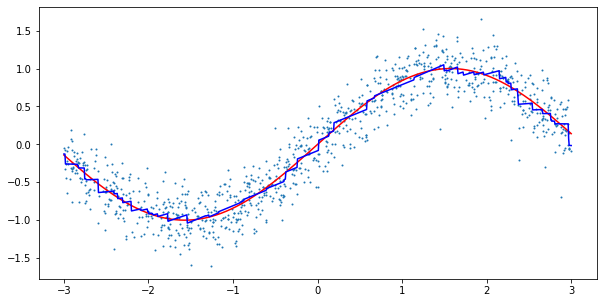

In [63]:
model = VaryingCoefficientGradientBoosting(n_estimators=250, learning_rate=0.025)

model.fit(X, y)

line = np.linspace(-3, 3, 1000).reshape(-1,1)

predictions = model.predict(line)

plt.figure(figsize=(10,5))
plt.plot(line, np.sin(line), c='r')
plt.plot(line, predictions, c='b')
plt.scatter(X, y, s=1)


Again, the results look reasonable. As our new model has a neat interpretability feature, let us also run the model on an actual dataset. Here, I chose the California Housing dataset from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html). The dataset contains information about housing prices in California in the 1990s. The goal is to predict the median house value in a given block based on the remaining features.

To make things more interesting, we will also compare the results against standard Gradient Boosting from sklearn. Keep in mind, though, that the evaluation process is really simple and should not be considered a proper benchmark.

In [64]:
housing = fetch_california_housing()
X = housing.data

y = housing.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)

X_mean = np.mean(X_train, 0)
X_std = np.std(X_train, 0)

X_train = (X_train - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

y_mean = np.mean(y_train)
y_std = np.std(y_train)

y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std



In [65]:
np.random.seed(123)

model = VaryingCoefficientGradientBoosting(n_estimators=100, max_depth=2, learning_rate = 0.1)
model.fit(X_train, y_train)

predictions_varcoeff = model.predict(X_test)

rmse_varcoeff = np.sqrt(np.mean((predictions_varcoeff - y_test)**2))


gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=2, learning_rate = 0.1)
gb_model.fit(X_train, y_train)

predictions_gb = gb_model.predict(X_test)

rmse_gb = np.sqrt(np.mean((predictions_gb - y_test)**2))

print(f"RMSE for varying coefficient model: {rmse_varcoeff}")
print(f"RMSE for gradient boosting model: {rmse_gb}")

RMSE for varying coefficient model: 0.4724723297379694
RMSE for gradient boosting model: 0.4893399365654721


This looks great. For the given hyperparameters and data, our approach is able to keep up with standard Gradient Boosting. Now, let us take a look at the coefficients of our model for a given input:

<AxesSubplot:>

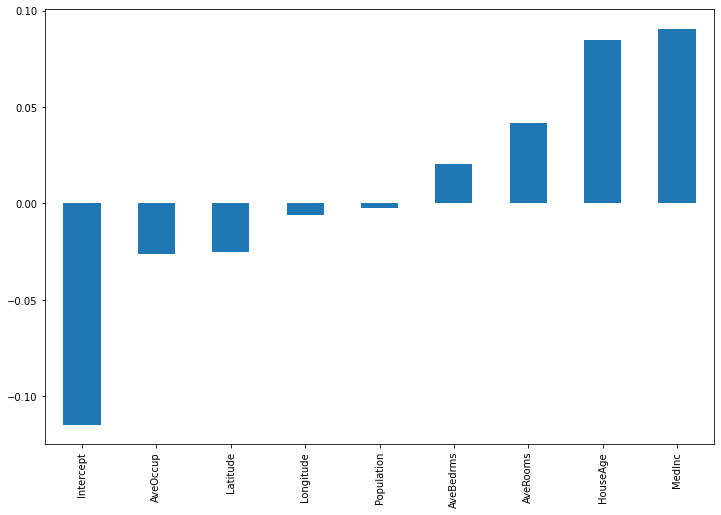

In [66]:
X_eval = np.concatenate([np.ones(shape=(1,1)), X_test[0,:].reshape(1,-1)], axis=1) 
#need to prepend the intercept column manually, since _predict_coeffs() expects it

importances = pd.Series(model._predict_coeffs(X_eval).reshape(-1), index=["Intercept"]+housing.feature_names)
importances.sort_values().plot(kind='bar', figsize=(12,8))


Besides the intercept, House Age and Median incomde appear to be the most important features for the given input. For another input observation, we get the following:

<AxesSubplot:>

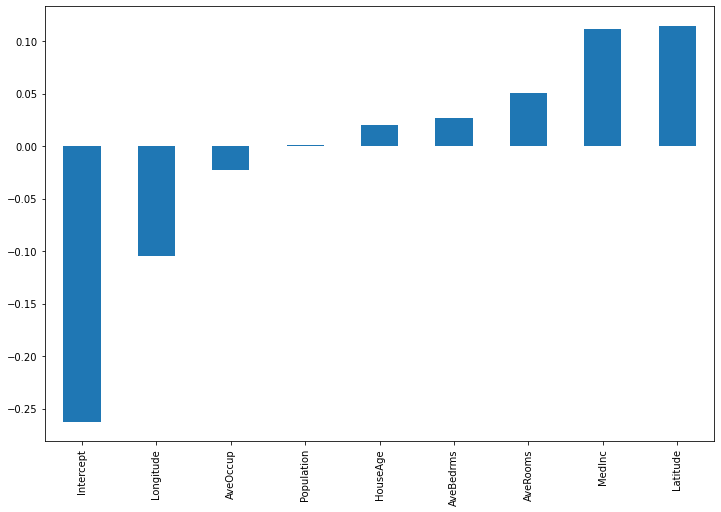

In [67]:
X_eval = np.concatenate([np.ones(shape=(1,1)), X_test[10,:].reshape(1,-1)], axis=1) 

importances = pd.Series(model._predict_coeffs(X_eval).reshape(-1), index=["Intercept"]+housing.feature_names)
importances.sort_values().plot(kind='bar', figsize=(12,8))


Here, the intercept term has much more relevance. Also, latitude and longitude are now the most influential features. 

It might be debatable whether the intercept term is actually sensible. Technically, removing all other coefficients and only keeping the intercept would result in standard Gradient Boosting. As the latter is already sufficiently powerful in itself, why use varying coefficients at all? On the other hand, removing the intercept entirely would result in a degenerate model for an all-zero input vector. 

The only possible prediction without an intercept term would then be zero as well, which is not what we want either. Another solution would be to model the intercept term as a constant, not via a Gradient Boosting model. As this would make the code more verbose, I decided to not do it here.

## Combining Deep Learning with Boosted Trees

If you are confident with your Calculus skills, our usage of PyTorch so far might seem rather unneccessary. After all, we could have just calculated the derivatives by hand, without requiring a full-blown framework like PyTorch. While this would require more manual work, it would also be more efficient computation-wise. For that reason, we will now look at an example, where manual differentiation is not a viable option if you want to maintain a healthy social life.

The idea is fairly simple: Use a Convolutional Neural Network but replace the elements of the last weight matrix with Gradient Boosting varying coefficients. As this could easily blow up model complexity (consider one Boosting model for each element in a $10\times10$ matrix), we only work with a rather simple example. In fact, we'll reduce the MNIST dataset to only 0s and 1s to get a binary classification problem. Also, we let the penultimate layer only have two neurons, to reduce the final weight matrix to size $2\times1$

The rest of the model is just a standard CNN with some arbitrary hyperparameters:

In [68]:
class ConvolutionalNetWithBoostedTrees:

    def __init__(self,
                 learning_rate: float = 0.025,
                 max_depth: int = 1,
                 n_estimators: int = 100, 
                 n_booster: int = 2):
        
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(7*7*32, 100)
        self.fc2 = torch.nn.Linear(100, n_booster)

        self.learning_rate: float = learning_rate
        self.max_depth: int = max_depth
        self.n_estimators: int = n_estimators

        self.boosted_trees: List[List[DecisionTreeRegressor]] = []

        self.init_coeffs: np.array = np.zeros(shape = (1, n_booster))

        self.is_trained: bool = False
        self.n_booster = n_booster


    def predict(self, X: np.array):
        x = torch.tensor(X).float()

        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, 2)
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 7*7*32)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x).detach().numpy()

        coeffs = self._predict_coeffs(X.reshape(-1, 28*28))

        logits = np.sum(x * coeffs, 1)

        #sigmoid
        return np.exp(logits) / (1 + np.exp(logits))
    

    def fit(self, X: np.array, y: np.array, batch_size: int = 500):
        self.is_trained = True

        for _ in range(self.n_estimators):
            idx = np.random.choice(len(X), batch_size, replace=False)
            X_batch = X[idx]
            y_batch = y[idx]
            self._fit_single_step(X_batch, y_batch)


    def _fit_single_step(self, X: np.array, y: np.array):

        X_2d = X.reshape(-1, 28*28)

        coeffs = self._predict_coeffs(X_2d)
        coeffs_var = Variable(torch.tensor(coeffs).float(), requires_grad=True)

        x = torch.tensor(X).float()
        y = torch.tensor(y).float()

        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, 2)
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 7*7*32)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)

        logit = (x * coeffs_var).sum(1)

        loss = torch.nn.functional.binary_cross_entropy_with_logits(logit, y)

        loss.backward()

        coeff_grads = coeffs_var.grad.numpy()
        self._update_booster(X_2d, -coeff_grads)

        self._update_network()

    def _update_network(self):
        self.conv1.weight.data -= self.learning_rate * self.conv1.weight.grad
        self.conv2.weight.data -= self.learning_rate * self.conv2.weight.grad
        self.fc1.weight.data -= self.learning_rate * self.fc1.weight.grad
        self.fc2.weight.data -= self.learning_rate * self.fc2.weight.grad

        self.conv1.weight.grad.zero_()
        self.conv2.weight.grad.zero_()
        self.fc1.weight.grad.zero_()
        self.fc2.weight.grad.zero_()


    def _update_booster(self, X: np.array, y: np.array) -> None:
        tree_list = []
        for c in range(self.n_booster):
            tree = DecisionTreeRegressor(max_depth=self.max_depth, min_samples_leaf=50)
            tree.fit(X, y[:,c])
            tree_list.append(tree)
            self.boosted_trees.append(tree_list)


    def _predict_coeffs(self, X: np.array) -> np.array:
        output = np.zeros(shape = (len(X), self.n_booster))

        output += self.init_coeffs

        for tree_list in self.boosted_trees:
            for c in range(self.n_booster):
                output[:,c] += self.learning_rate * tree_list[c].predict(X)

        return output

Since we do all calculations except gradient by hand, our model class does not inherit from ```torch.nn.Module``` here. Also, the ```fit``` methods are now slightly different from before, which is due to the additional parameters that we need to learn. For each layer that doesn't use Gradient Boosting, we need to manually implement the gradient steps. Think of this like fitting depth-0 Decision Trees (constant predictions) to a constant target for any input. 

I.e., our model consists of a parameter vector, that is comprised of many constant and two varying parameters. The latter are the ones we want to model with Boosted Trees:

$$\theta(x)=\begin{pmatrix}\theta^{(1)} \\ \vdots \\ \theta^{(K)} \\ \theta^{(K+1)}(x) \\ \theta^{(K+2)}(x)\end{pmatrix}$$

At each gradient descent step, the constant parameters are updated as usual, while the varying parameters are updated via Gradient Boosting:

$$
\theta_m(x)=\begin{pmatrix}
\theta_{m}^{(1)} \\ \vdots \\ \theta_{m}^{(K)} \\ \theta_{m}^{(K+1)}(x) \\ \theta_{m}^{(K+2)}(x)
\end{pmatrix} = 
\begin{pmatrix}
\theta_{m-1}^{(1)} \\ \vdots \\ \theta_{m-1}^{(K)} \\ \theta_{m-1}^{(K+1)}(x) \\ \theta_{m-1}^{(K+2)}(x)
\end{pmatrix} - \gamma \cdot 
\begin{pmatrix}
\frac{\partial L(\theta_{m-1}(x),x,y)}{\partial \theta_{m-1}^{(1)}} \\ \vdots \\ \frac{\partial L(\theta_{m-1}(x),x,y)}{\partial \theta_{m-1}^{(K)}} \\ \frac{\partial L(\theta_{m-1}(x),x,y)}{\partial \theta_{m-1}^{(K+1)}(x)} \\ \frac{\partial L(\theta_{m-1}(x),x,y)}{\partial \theta_{m-1}^{(K+2)}(x)}
\end{pmatrix}
$$

For clarity, our loss now also depends explicitly on the input $x$, not only via $\theta(x)$. The first $K$ elements are then updated in 

```python
def _update_network(self):
    self.conv1.weight.data -= self.learning_rate * self.conv1.weight.grad
    self.conv2.weight.data -= self.learning_rate * self.conv2.weight.grad
    self.fc1.weight.data -= self.learning_rate * self.fc1.weight.grad
    self.fc2.weight.data -= self.learning_rate * self.fc2.weight.grad

    self.conv1.weight.grad.zero_()
    self.conv2.weight.grad.zero_()
    self.fc1.weight.grad.zero_()
    self.fc2.weight.grad.zero_()
```

while the Boosting models are updated in 

```python
def _update_booster(self, X: np.array, y: np.array) -> None:
    tree_list = []
    for c in range(self.n_booster):
        tree = DecisionTreeRegressor(max_depth=self.max_depth, min_samples_leaf=50)
        tree.fit(X, y[:,c])
        tree_list.append(tree)
        self.boosted_trees.append(tree_list)
```

As we are dealing with binary classification, we can use the [Binary Cross-Entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) loss directly from PyTorch. Notice that we use the logits for the training steps, i.e. the network output before applying the sigmoid activation function.

To speed things up, we also allow for random batch sampling which effectively makes this a Stochastic Gradient Descent algorithm. This is not strictly necessary, but it makes the training process much faster, in particular for the Boosting models.

Now, let us test our model on the MNIST dataset:

In [69]:
import torchvision

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True)

X_train = mnist_train.data.numpy()
y_train = mnist_train.targets.numpy()

X_test = mnist_test.data.numpy()
y_test = mnist_test.targets.numpy()

X_train = X_train[(y_train == 0) | (y_train == 1)]
y_train = y_train[(y_train == 0) | (y_train == 1)]

X_test = X_test[(y_test == 0) | (y_test == 1)]
y_test = y_test[(y_test == 0) | (y_test == 1)]


X_train = X_train.reshape(-1, 1, 28, 28)
X_test = X_test.reshape(-1, 1, 28, 28)

In [70]:
np.random.normal(123)
torch.manual_seed(123)

model = ConvolutionalNetWithBoostedTrees(n_estimators=50, max_depth=3, learning_rate = 0.001)
model.fit(X_train, y_train, batch_size=500)

#evaluate
y_pred = model.predict(X_test)
np.mean(np.round(y_pred) == y_test)

0.992434988179669

Although this is a toy problem, almost 100% test accuracy is good. We can have confidence that our approach works in principle. As some final shenanigans, let us also consider a measure of local feature importance, concerning the boosting models. For a given input, each pixel and all Decision Trees, we count how often the given pixel (=feature) is encountered in each split rule. Then we can plot the result in an image plot:

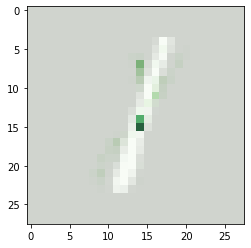

In [87]:
# get all features in each node from root to leaf that target_x traverses in target_tree

def get_features_in_path(target_tree, target_x):
    nodes = []
    node = 0
    nodes.append(node)
    while node != -1:
        if target_x[target_tree.tree_.feature[node]] < target_tree.tree_.threshold[node]:
            node = target_tree.tree_.children_left[node]
        else:
            node = target_tree.tree_.children_right[node]
        nodes.append(node)

    #get all features in each node from root to leaf
    feature_importances = np.zeros(28*28)
    for node in nodes:
        if node != -1:
            target_feature = target_tree.tree_.feature[node]
            if target_feature > -1:
                feature_importances[target_feature] += 1
    return feature_importances.reshape(28,28)

target_x = X_test[0].reshape(-1)

feature_importance = np.zeros(shape = (28,28))

for tree_list in model.boosted_trees:
    for tree in tree_list:
        feature_importance += get_features_in_path(tree, target_x) 

plt.imshow(target_x.reshape(28,28), cmap='gray')
plt.imshow(feature_importance, cmap='Greens', alpha=0.85)


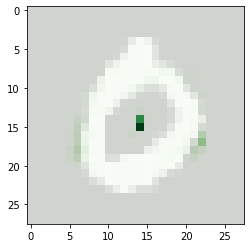

In [88]:
target_x = X_test[1].reshape(-1)

feature_importance = np.zeros(shape = (28,28))

for tree_list in model.boosted_trees:
    for tree in tree_list:
        feature_importance += get_features_in_path(tree, target_x) 

plt.imshow(target_x.reshape(28,28), cmap='gray')
plt.imshow(feature_importance, cmap='Greens', alpha=0.85)


This could be interpreted as follows: The primary region of interest is around the center of the image (the deep green dots). 1s are mostly colored around there, while 0s will usually be blank around the center. In the bottom case of the 0, we see also some light regions at the left and right edges of the digit being of interest. 

Keep in mind that this is just a freestyled measure of feature importance. We don't even consider the remaining CNN parts of our model which is clearly insufficient. On the other hand, the output looks still reasonable and gives us at least some idea of what the model is doing. 

In addition, larger or actual RGB images will likely be much harder to get right with this kind of model in general. Nevertheless, we have created a Gradient Boosting model where using PyTorch is actually a life-saver. 

## Conclusion
As we have seen, marrying Gradient Boosting with PyTorch can be a useful approach. Although manual derivatives will be faster, PyTorch allows us to handle arbitrarily complex models holistically. Since Gradient Boosting is generally a very powerful model, this might create opportunity to improve existing approaches that usually don't include a Boosting component.

This also comes with a slight improvement for interpretability, as tree based methods provide at least some insight into a model's inner workings. In one of the next articles, we'll take a look how this all can also be used for time series models.

## References
**[1]** Friedman, Jerome H. Greedy function approximation: A gradient boosting machine. Annals of statistics, 2001

**[2]** Hastie, Trevor; Tishbirani, Robert. Varying-coefficient models. Journal of the Royal Statistical Society Series B: Statistical Methodology, 1993

**[2]** Paszke, Adam, et al. Pytorch: An imperative style, high-performance deep learning library. Advances in neural information processing systems, 2019
